<a href="https://colab.research.google.com/github/l-arkadiy-l/---Mini-projects---/blob/main/GOTO_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
files.upload()



KeyboardInterrupt: ignored

In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets list

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
api.dataset_download_files('kmader/skin-cancer-mnist-ham10000', 'HAM10000_images_part_2')

In [ ]:
import zipfile
path_to_zip_file = '/content/HAM10000_images_part_1/skin-cancer-mnist-ham10000.zip'
with zipfile.ZipFile('/content/HAM10000_images_part_2/skin-cancer-mnist-ham10000.zip', 'r') as z:
    z.extractall('/content/HAM10000_images_part_1')

In [4]:
# ----- start coding
import pandas as pd
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.model_selection import train_test_split
from torch import optim

In [5]:
name_folder = '/content/HAM10000_images_part_1'
data = pd.read_csv(f'{name_folder}/HAM10000_metadata.csv')
data = data.head(data.size)
dict_sex = {
    'male': 0, 
    'female': 1
}
dict_disease = {
    'mel': 0, 
    'bkl': 1, 
    'df': 2, 
    'nv': 3, 
    'bcc': 4, 
    'vasc': 5, 
    'akiec': 6
    }
dict_type = {
    'follow_up': 0,
    'consensus': 1, 
    'confocal': 2, 
    'histo': 3
}

dict_localization = {
    'back': 0, 
    'ear': 1, 
    'scalp': 2, 
    'lower extremity': 3, 
    'hand': 4, 
    'foot': 5, 
    'acral': 6, 
    'chest': 7, 
    'trunk': 8,
    'genital': 9, 
    'neck': 10,
    'abdomen': 11,
    'upper extremity': 12, 
    'face': 14
}

for j in data.iterrows():
    # print(j[1]['sex'], j[1]['image_id'], data[data['image_id'] == j[1]['image_id']])
    # img = Image.open(f"/HAM10000_images/{j[1][1]}.jpg")
    try:
        data.at[j[0], 'sex'] = dict_sex[j[1]['sex']]
        data.at[j[0], 'dx'] = dict_disease[j[1]['dx']]
        data.at[j[0], 'dx_type'] = dict_type[j[1]['dx_type']]
        data.at[j[0], 'localization'] = dict_localization[j[1]['localization']]
        # print(data[data['image_id'] == j[1]['image_id']])
    except KeyError:
        # print('unknow')
        data[data['image_id'] == j[1]['image_id']] = ''
        pass
data.to_csv(f'{name_folder}/test.csv', index=False)


In [6]:
img_width, img_height = (600, 450)

In [7]:
data = pd.read_csv(f'{name_folder}/hmnist_28_28_RGB.csv')
x = torch.from_numpy(data.values)[:, :-1]
y = torch.from_numpy(data.values)[:, -1]
x_train, x_test, y_train, y_test = train_test_split(x, y)
dataset = torch.utils.data.TensorDataset(x_train, y_train)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

testset = torch.utils.data.TensorDataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True)
# print(torch.utils.data.TensorDataset())
print(x_train, y_train)


tensor([[182, 144, 144,  ..., 145, 115, 113],
        [126, 110, 119,  ..., 123, 113, 123],
        [164, 115, 122,  ..., 145,  97,  81],
        ...,
        [170,  88, 114,  ..., 166, 107, 113],
        [160, 145, 127,  ..., 174, 164, 154],
        [178, 124, 131,  ..., 183, 135, 161]]) tensor([4, 4, 4,  ..., 4, 4, 0])


In [87]:

model = nn.Sequential(
    nn.Conv2d(3, 64, 3, 1),
    nn.GELU(),
    nn.Conv2d(64, 128, 3, 1), 
    nn.GELU(),
    nn.Conv2d(128, 256, 3, 1),
    nn.GELU(),
    nn.Flatten(),
    nn.Linear(123904, 7),
    nn.LogSoftmax(dim=1)
)
model = model.cuda()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 7
for i in range(epochs):
  running_loss = 0
  for images, labels in data_loader:
    
    images = images.reshape(-1, 3, 28, 28).type(torch.cuda.FloatTensor).cuda()
    labels = labels.cuda()
    loss = criterion(model(images), labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    running_loss += loss.item()
  print(f'Training Loss: {running_loss / len(data_loader)}')


Training Loss: 35.951213853844145
Training Loss: 0.8951788100145631
Training Loss: 0.8367783285803714
Training Loss: 0.7906355756824299
Training Loss: 0.743616792105012
Training Loss: 0.7139746238619594
Training Loss: 0.7022746084100109


In [ ]:
87*3*28**2

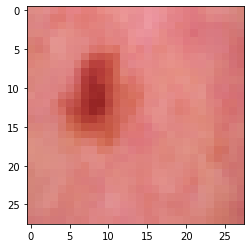

In [65]:
dict_labels = {0: '(akiec)', 1: '(bcc)', 2: '(bkl)', 3: 'dermatofibroma (df)', 4:'melanoma (mel)', 5: 'melanocytic nevi (nv)', 6: 'vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc)', 7: ''}


In [10]:
import torch
def calc_accuracy(output, labels):
  dict_cnt = {i : 0 for i in range(7)}
  ans_labels = torch.argmax(output, dim=1) # ans_labesl = pred_labels = y с крышкой
  coincidence = labels.cuda() == ans_labels.cuda()
  coincidence = coincidence.type(torch.cuda.FloatTensor) # from bool to float
  tm = torch.mean(coincidence)
  return [tm, ans_labels]

tensor(0.4219, device='cuda:0')


TypeError: ignored

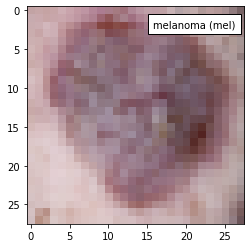

In [101]:
from matplotlib import pyplot as plt
dataiter = iter(data_loader)
# print(images.shape)
output = model(images.reshape(-1, 3, 28, 28).type(torch.cuda.FloatTensor).cuda())
for i in range(20):
  images, labels = dataiter.next() # бач картинок и ответов (меток)
  tm, ans_labels = calc_accuracy(output, labels.cuda())
  print(tm)
  # print(images[0].view(-1, 3, 28, 28))
  plt.imshow(images[0].view(28, 28, 3))
  ind = ans_labels[0].cpu().numpy()
  # print(dict_labels[int(ind)])
  plt.text(.96,.94,dict_labels[int(ind)], bbox={'facecolor':'w','pad':5},
         ha="right", va="top", transform=plt.gca().transAxes )
  helper.view_classify(images[0].view(28, 28, 3),  torch.exp(tm))
  break




(28, 28, 3)


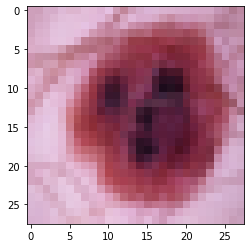

In [56]:
from matplotlib import pyplot as plt

for images, labels in data_loader:
  a = images.cpu().numpy()
  a = a.view().reshape(-1,  28, 28, 3)
#   print(a)
#   # break
# print(a)
plt.imshow(a[3])
print(a[3].shape)

In [33]:
%matplotlib inline
import helper

images, labels = dataiter.next()

img = images[0].reshape(-1, 3, 28, 28).type(torch.cuda.FloatTensor).cuda()
label = labels[0]
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)
    print(logps)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
print('--->', calc_accuracy(images, labels))
# helper.view_classify(img.view(3, 28, 28).cpu(), ps.cpu())

tensor([[-6.8007e+00, -9.4411e+00, -5.9392e+00, -9.7141e+00, -8.2490e-03,
         -7.5755e+00, -5.5688e+00]], device='cuda:0')
---> [tensor(0., device='cuda:0'), tensor([   3,  359,    3,   54, 2238,  915,   36,  977,   66, 1442,   30, 2307,
           8,  261,   24,   48,  222, 1242,   45, 1467,    0,   33,   27,  846,
        2286,  287,  810,  278,  672,  203,  722, 2070, 1311, 1410, 1029,  311,
          54,   57,   48, 1403,  821,  278,  201, 1352,  270,  885, 2310,   45,
        1814, 1956,  354,  863,   33,  540,   36, 1290,   45,  161, 1983, 1047,
        1464,   21,   39,  537,  323,  183,   69,   66,  497,  981, 1875,  986,
          36, 1365, 1943,   21, 1038,   33,   54,   27,   54,  353,   21, 1688,
         105,   63,   51, 1982,   39,   36,  450,   42, 1146, 1818,   51,   51,
         197, 1625,   21,  627,   54,   27,    6, 1364, 2331, 1665, 1578, 1818,
          12,   57,  561,   21, 1637,   48,  762,   27, 1967,   45,  870,  462,
        2340,   42, 2031,   51, 1028,